In [2]:
#saccades
#three or five digits
#transparsenecy 

In [1]:
%cd /Users/typhaine/Documents/Doc_Gorilla/WhereIsMyMNIST/notebooks

/Users/typhaine/Documents/Doc_Gorilla/WhereIsMyMNIST/notebooks


In [2]:
import os
import imageio
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import pygame
from psychopy import visual, core, event, gui, data

from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST, MotionCloudNoise
import MotionClouds as mc

from main import init
args = init(filename='../data/2019-06-12') # pas de drop out!
args


pygame 2.0.1 (SDL 2.0.14, Python 3.7.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-12',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [85]:
## Unit tests

#transforms.GaussianBlur(kernel_size = 1, sigma=(0.1, 2.0))
transform=transforms.Compose([
                               WhatShift(args,i_offset=0, j_offset=0),
                               WhatBackground(contrast = args.contrast,
                                              noise=0, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               transforms.Normalize((args.mean,), (args.std,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

data, label = next(iter(train_loader))
#%timeit data, label = next(iter(train_loader))
print(label.shape)
print(data.shape)

torch.Size([100])
torch.Size([100, 1, 128, 128])


In [4]:
def add(data):
    data = data.numpy().reshape(100,128,128)
    return np.array([numbers(data) for i in range(100)]).reshape(100,128,128)

In [5]:
def numbers(data):
    num = [
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(-50,-30)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(-50,-30)),
    random_roll(data[random.randint(0,99)],random.randint(-50,-30),random.randint(0,20)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(-50,-20)),
    random_roll(data[random.randint(0,99)],random.randint(30,50),random.randint(0,20)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(30,50)),
    random_roll(data[random.randint(0,99)],random.randint(0,20),random.randint(0,20))]
    np.random.shuffle(num)
    return np.max((num[0:random.randint(1,9)]),axis = 0)

In [6]:
def RGBA(data):
    data = np.interp(data, (data.min(), data.max()), (0, 1))
    alpha = np.ones((data.shape[0],128,128))
    return np.stack((data,data,data,alpha),axis=-1)

In [7]:
def random_roll(data, x_shift, y_shift):
    return np.roll(np.roll(data, x_shift, axis = 0), y_shift, axis = 1)

In [8]:
def motion(data,background):
    data = np.interp(data, (data.min(), data.max()), (0, 1))
    background = np.reshape(RGBA(background),(128,128,4))
    return np.swapaxes(
        np.moveaxis(
            np.array([[
                np.max((
                    np.roll(background,back,axis =(0,1)),data[D,:,:,:]),axis=0) 
                for back in range(60)] 
                for D in range(data.shape[0])]),(0,1,2,3,4),(0,1,4,3,2)),3,4)

# np.swapaxes(x,3,4)
#np.moveaxis(x,(0,1,2,3,4),(0,1,4,3,2))
            

In [9]:
def transparency(data):
    [[[np.put(img[frame,3,row,:],np.where(img[frame,0,row,:]>0.9),np.linspace(0, 1, num=60)[frame]) 
       for row in range(128)] 
      for frame in range(60)] for img in data]



In [86]:
#%timeit z, env = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf, alpha=.0, N_pic=128, seed=42, motion = True)
z, env = MotionCloudNoise(sf_0=args.sf_0, B_sf=args.B_sf, alpha=.0, N_pic=128, seed=42, motion = True)
#%timeit motion(RGBA(add(data)),np.moveaxis(z,(0,1,2),(2,1,0)))
data = motion(RGBA(add(data)),np.moveaxis(z,(0,1,2),(2,1,0)))
#%timeit transparency(data)
transparency(data)


In [121]:
def Random_Sac(Number_of_digits,Number_of_frames):
    return np.random.randint(0,128, size = (Number_of_digits,Number_of_frames,2)) # maybe (:,:,2)
saccades = Random_Sac(100,60)


array([ 23, 101])

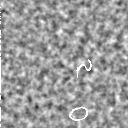

In [30]:

test = data[0,0,:,:,:]
test[0,:,:] =  np.interp(test[0,:,:], (test[0,:,:].min(), test[0,:,:].max()), (0, 255))
test[1,:,:] =  np.interp(test[1,:,:], (test[1,:,:].min(), test[1,:,:].max()), (0, 255))
test[2,:,:] =  np.interp(test[2,:,:], (test[2,:,:].min(), test[2,:,:].max()), (0, 255))
#print(np.where(test[2,:,:]>229))
test[3,:,:] = np.linspace(0, 255, num=60)[50]
test = test.astype('uint8')
np.put(test[3,:,:],np.where(test[0,:,:]>229),np.linspace(0, 255, num=60)[0])
test = np.moveaxis(test,(0,1,2),(2,1,0))

Image.fromarray(test, "RGBA")

In [70]:
instructions = """
At each trial you see a series of textured images, report if you 
spot a specific digit by pressing the space bar.

Press the space bar to begin the experiment.

"""

win = visual.Window(winType = 'pyglet', size =(800,800), colorSpace = "rgb")

message = visual.TextStim(win, text= instructions)
message.autoDraw = True  # Automatically draw every frame
win.flip()
core.wait(5.0)
message.text = ''  # Change properties of existing stim
win.flip()
core.wait(0.0)

while True:
    for i in range(data.shape[0]-1):
            mov = data[i]
            for ii in range(mov.shape[0]):
                movie_clip = visual.ImageStim(win, np.moveaxis(mov[ii],(0,1,2),(2,1,0)), colorSpace = "rgb", contrast = 1, size = 2, flipVert=True)
                movie_clip.draw()
                win.flip()

(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 

KeyboardInterrupt: 

In [131]:

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

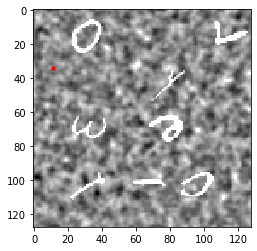

In [132]:
data = data.reshape(6000,4,128,128)
test = data[1]
test = np.moveaxis(test,(0,1,2),(2,1,0))
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[0], landmarks[1], s=10, marker='o', c='r') 

plt.figure()
show_landmarks(test,
               saccades[1][1])
plt.show()

In [151]:
class LandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, image, landmarks, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks = landmarks
        self.image = image
        self.transform = transform

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.image[idx]
        image = np.moveaxis(image,(0,1,2),(2,1,0))
        landmarks = self.landmarks[idx]
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (128, 128, 4) (60, 2)
1 (128, 128, 4) (60, 2)
2 (128, 128, 4) (60, 2)
3 (128, 128, 4) (60, 2)


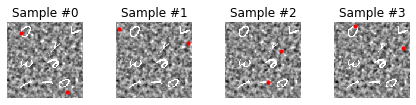

In [152]:
face_dataset = LandmarksDataset(data,saccades)


fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [183]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [184]:
transformed_dataset =  LandmarksDataset(data,saccades, transform=transforms.Compose([ToTensor()]))



for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([4, 128, 128]) torch.Size([60, 2])
1 torch.Size([4, 128, 128]) torch.Size([60, 2])
2 torch.Size([4, 128, 128]) torch.Size([60, 2])
3 torch.Size([4, 128, 128]) torch.Size([60, 2])


In [224]:
%cd /Users/typhaine/Documents/Doc_Gorilla/POLO/dev
from PYramid import cropped_pyramid
class CroppedPyramid(object):
    def __init__(self, width, base_levels, color=True, do_mask=False, verbose=True):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
    
    def __call__(self, sample):
        img_crop, level_size = cropped_pyramid(sample['image'].unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True)
        return{'img_crop':img_crop, 'level_size':level_size, 'pos':sample['pos']}

/Users/typhaine/Documents/Doc_Gorilla/POLO/dev


In [225]:
width=32
base_levels=2
from LogGabor import LogGabor
from PYramid import local_filter
from PYramid import get_K
from PYramid import log_gabor_transform

In [226]:
n_sublevel = 2 
n_azimuth = 12 
n_theta = 12
n_phase = 2

pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg','jpeg'], 'dpi': 450, 'verbose': 0}   

lg = LogGabor(pe)
K = get_K(width=width,
            n_sublevel = n_sublevel, 
            n_azimuth = n_azimuth, 
                  n_theta = n_theta,
                  n_phase = n_phase, 
                  r_min = width/6, 
                  r_max = width/3, 
                  log_density_ratio = 2, 
                  verbose=False)

In [227]:
class LogGaborTransform(object):
    def __init__(self, K=K, color=True, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose
    
    def __call__(self, sample):
        log_gabor_coeffs = log_gabor_transform(sample['img_crop'].unsqueeze(0), K)
        
        return{'img_gabor':log_gabor_coeffs, 'K':K}

In [228]:
#RandomSaccadeTo()
composed_transform = transforms.Compose([
                               ToTensor(),
                               CroppedPyramid(width, base_levels), LogGaborTransform()])

In [229]:
transformed_dataset =  LandmarksDataset(data,saccades, transform=composed_transform)

In [230]:
pattern = 'i05june05_static_street_boston_p1010808'

In [231]:
print(transformed_dataset[1])

Tensor shape= torch.Size([1, 4, 64, 64]) , shape= torch.Size([1, 4, 128, 128])


RuntimeError: The expanded size of the tensor (3) must match the existing size (4) at non-singleton dimension 1.  Target sizes: [1, 3, 32, 32].  Tensor sizes: [4, 32, 32]